# Klastrowanie metodami K-means i K-medoids

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image, display, HTML
from pyclustering.cluster import kmeans, kmedoids, cluster_visualizer_multidim
from sklearn.metrics.cluster import fowlkes_mallows_score, silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize']=25,11
plt.style.use('seaborn-whitegrid')

display(HTML("<style>.container { width:80% !important; }</style>"))

## 1. Wybrany zbiór - Heart Disease UCI

In [9]:
df = pd.read_csv("heart-disease-uci/heart.csv")

In [10]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.2 KB


In [12]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [13]:
true_labels = df.target
df.drop('target',inplace=True,axis=1)
df.loc[:,:] = StandardScaler().fit_transform(df)

## Standaryzacja zbioru w celu usunięcia błędu wynikającego z różnicy rzędów wielkości zmiennych + wyrzucenie targetu

In [14]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
count,3.030000e+02,3.030000e+02,3.030000e+02,3.030000e+02,3.030000e+02,3.030000e+02,3.030000e+02,3.030000e+02,3.030000e+02,3.030000e+02,3.030000e+02,3.030000e+02,3.030000e+02
mean,5.825923e-17,-1.319077e-17,-5.562565e-17,-7.146832e-16,-9.828955e-17,-3.664102e-19,2.652810e-16,-5.203025e-16,-5.203025e-16,-3.140136e-16,1.355718e-16,4.752341e-16,3.484561e-16
std,1.001654e+00,1.001654e+00,1.001654e+00,1.001654e+00,1.001654e+00,1.001654e+00,1.001654e+00,1.001654e+00,1.001654e+00,1.001654e+00,1.001654e+00,1.001654e+00,1.001654e+00
min,-2.797624e+00,-1.468418e+00,-9.385146e-01,-2.148802e+00,-2.324160e+00,-4.176345e-01,-1.005832e+00,-3.439267e+00,-6.966305e-01,-8.968617e-01,-2.274579e+00,-7.144289e-01,-3.784824e+00
25%,-7.572802e-01,-1.468418e+00,-9.385146e-01,-6.638668e-01,-6.814943e-01,-4.176345e-01,-1.005832e+00,-7.061105e-01,-6.966305e-01,-8.968617e-01,-6.491132e-01,-7.144289e-01,-5.129219e-01
50%,6.988599e-02,6.810052e-01,3.203122e-02,-9.273778e-02,-1.210553e-01,-4.176345e-01,8.989622e-01,1.466343e-01,-6.966305e-01,-2.067053e-01,-6.491132e-01,-7.144289e-01,-5.129219e-01
75%,7.316189e-01,6.810052e-01,1.002577e+00,4.783913e-01,5.456738e-01,-4.176345e-01,8.989622e-01,7.151309e-01,1.435481e+00,4.834512e-01,9.763521e-01,2.650822e-01,1.123029e+00
max,2.496240e+00,6.810052e-01,1.973123e+00,3.905165e+00,6.140401e+00,2.394438e+00,2.803756e+00,2.289429e+00,1.435481e+00,4.451851e+00,9.763521e-01,3.203615e+00,1.123029e+00


In [15]:
pca = PCA(n_components=2)
pca.fit(df)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

## 2. Wybór optymalnej liczby klastrów

In [16]:
def clusters_to_labels(clusters):
    n = sum(map(len, clusters))
    labels = np.repeat(0, n)
    for i, cluster in enumerate(clusters):
        labels[cluster] = i
    return labels

def get_kmeans_stats(k):
    observer = kmeans.kmeans_observer()
    algo_instance = kmeans.kmeans(df, df.loc[np.random.choice(np.arange(df.shape[0]),size=k,replace=False)])
    algo_instance.process()
    centers = algo_instance.get_centers()
    clusters = algo_instance.get_clusters()
    score = algo_instance.get_total_wce()
    return centers, clusters_to_labels(clusters)

def get_kmedoids_stats(k):
    algo_instance = kmedoids.kmedoids(df.values, np.random.choice(np.arange(df.shape[0]),size=k,replace=False))
    algo_instance.process()
    medoids = algo_instance.get_medoids()
    centers = df.loc[medoids]
    clusters = algo_instance.get_clusters()
    return centers, clusters_to_labels(clusters)

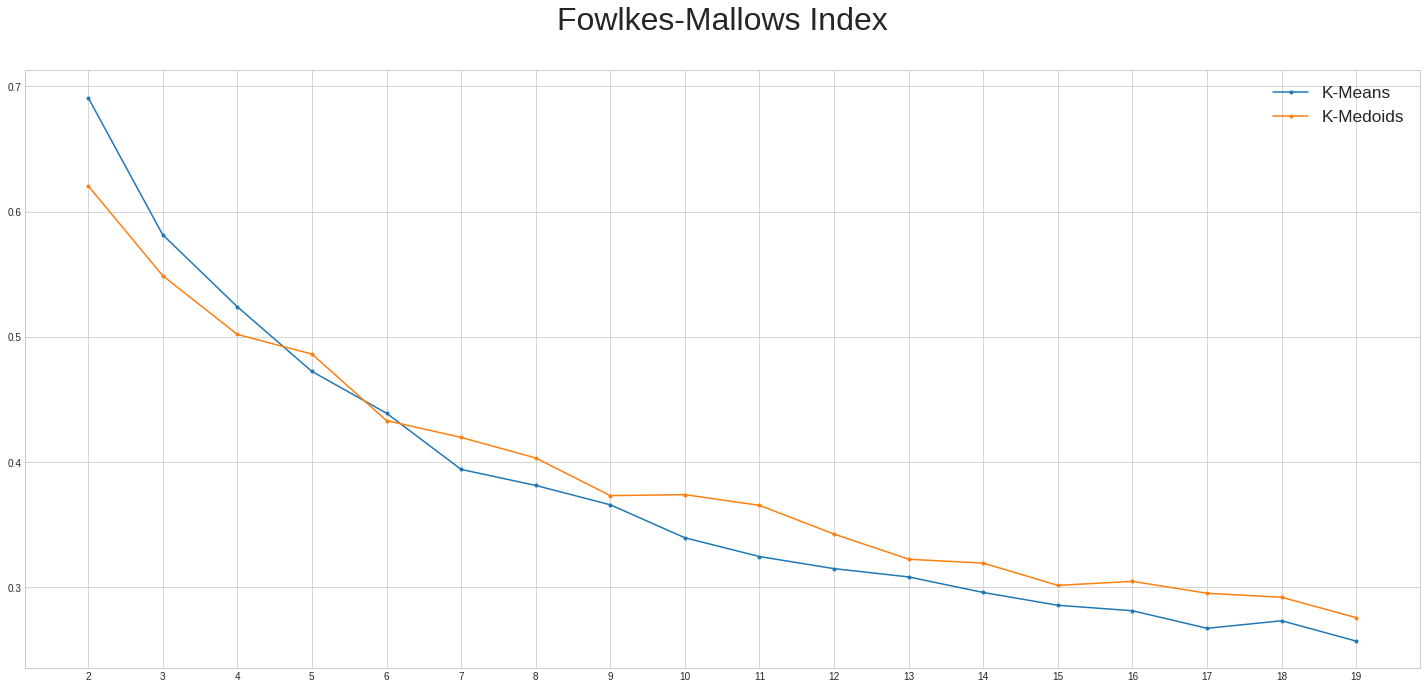

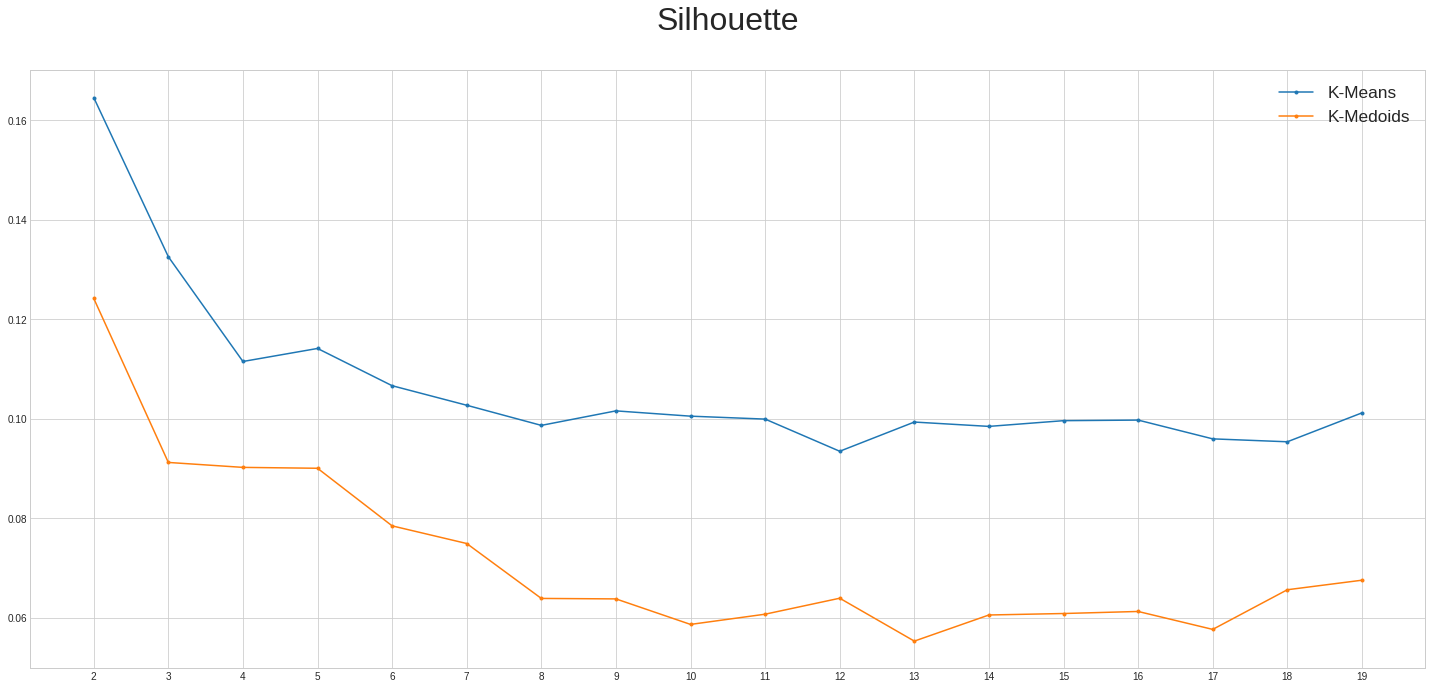

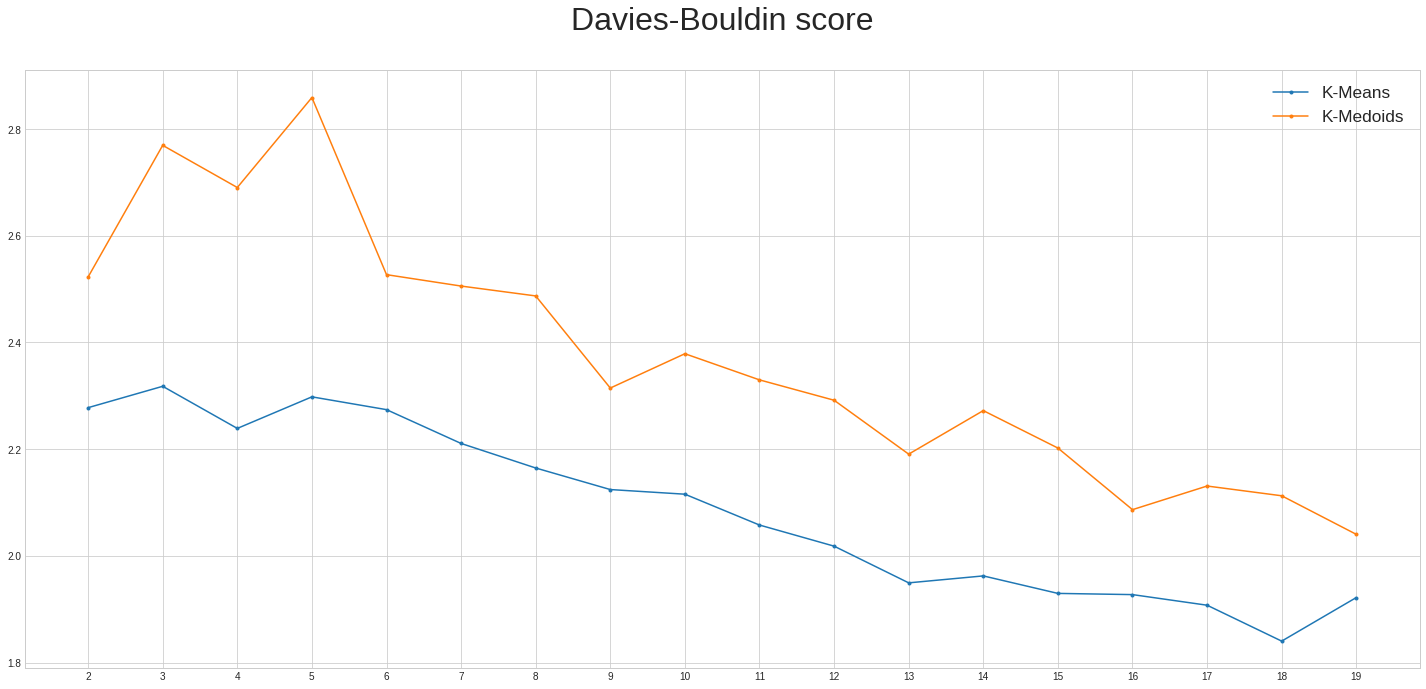

In [17]:
plt.plot(np.arange(2,20), [np.mean([fowlkes_mallows_score(true_labels, get_kmeans_stats(k)[1]) for _ in range(10)]) for k in np.arange(2,20)],marker='.',label="K-Means")
plt.plot(np.arange(2,20), [np.mean([fowlkes_mallows_score(true_labels, get_kmedoids_stats(k)[1]) for _ in range(10)]) for k in np.arange(2,20)],marker='.',label="K-Medoids")
plt.legend(fontsize='xx-large')
plt.xticks(np.arange(2,20))
plt.title("Fowlkes-Mallows Index\n", size=32)
plt.show()
plt.plot(np.arange(2,20), [np.mean([silhouette_score(df, get_kmeans_stats(k)[1]) for _ in range(10)]) for k in np.arange(2,20)],marker='.',label="K-Means")
plt.plot(np.arange(2,20), [np.mean([silhouette_score(df, get_kmedoids_stats(k)[1]) for _ in range(10)]) for k in np.arange(2,20)],marker='.',label="K-Medoids")
plt.legend(fontsize='xx-large')
plt.xticks(np.arange(2,20))
plt.title("Silhouette\n", size=32)
plt.show()
plt.plot(np.arange(2,20), [np.mean([davies_bouldin_score(df, get_kmeans_stats(k)[1]) for _ in range(10)]) for k in np.arange(2,20)],marker='.',label="K-Means")
plt.plot(np.arange(2,20), [np.mean([davies_bouldin_score(df, get_kmedoids_stats(k)[1]) for _ in range(10)]) for k in np.arange(2,20)],marker='.',label="K-Medoids")
plt.legend(fontsize='xx-large')
plt.xticks(np.arange(2,20))
plt.title("Davies-Bouldin score\n", size=32)
plt.show()

### Wybór - 4 klastry dla K-means, 6 klastrów dla K-medoids

## 3. Porównanie klastrów i ich centrów

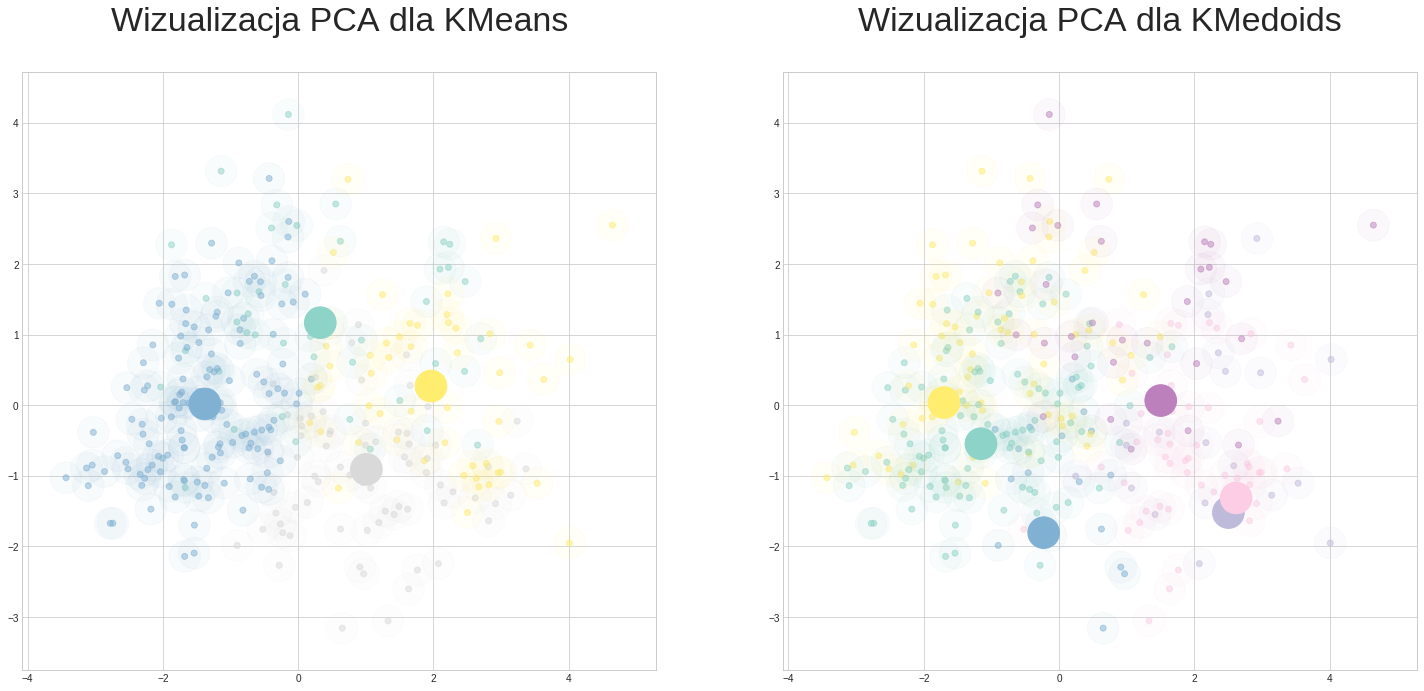

In [105]:
transformed_df = pca.transform(df)
plt.subplot(1,2,1)
plt.title('Wizualizacja PCA dla KMeans\n', size = 34)
kmeans_centers, kmeans_labels = get_kmeans_stats(4)
plt.scatter(*transformed_df.transpose(), c=kmeans_labels,cmap='Set3',alpha = 0.5)
plt.scatter(*transformed_df.transpose(), c=kmeans_labels,cmap='Set3',s=1000,alpha=0.05)
plt.scatter(*pca.transform(np.array(kmeans_centers)).transpose(),cmap='Set3', s=1000, c=np.arange(4))

plt.subplot(1,2,2)
plt.title('Wizualizacja PCA dla KMedoids\n', size = 34)
kmedoids_centers, kmedoids_labels = get_kmedoids_stats(6)
plt.scatter(*transformed_df.transpose(), c=kmedoids_labels,cmap='Set3',alpha = 0.5)
plt.scatter(*transformed_df.transpose(), c=kmedoids_labels,cmap='Set3',s=1000,alpha=0.05)
plt.scatter(*pca.transform(np.array(kmedoids_centers)).transpose(),cmap='Set3', s=1000, c=np.arange(6))
plt.show()

Algorytm KMeans znalazł klastry, które są w miarę oddalone od siebie i dzielą nam zbiór na cztery części. Optymalny wynik algorytmu KMedoids zwrócił nam wynik bardzo podobny, tylko w dwóch przypadkach z podwójnymi centroidami. Może to oznaczać, że faktyczna liczba klastrów powinna być równa 4. Jest to zgodne z prawdą ponieważ zbiór danych posiada cztery klasy.


## 4. Zbieżność algorytmów

Zbadanie zbieżności algorytmów wymagało ode mnie modyfikacji biblioteki, ale nie było to zbyt trudne. Jak widzimy poniżej, algorytm K-medoids zbiega znacznie szybciej od algorytmu K-Means

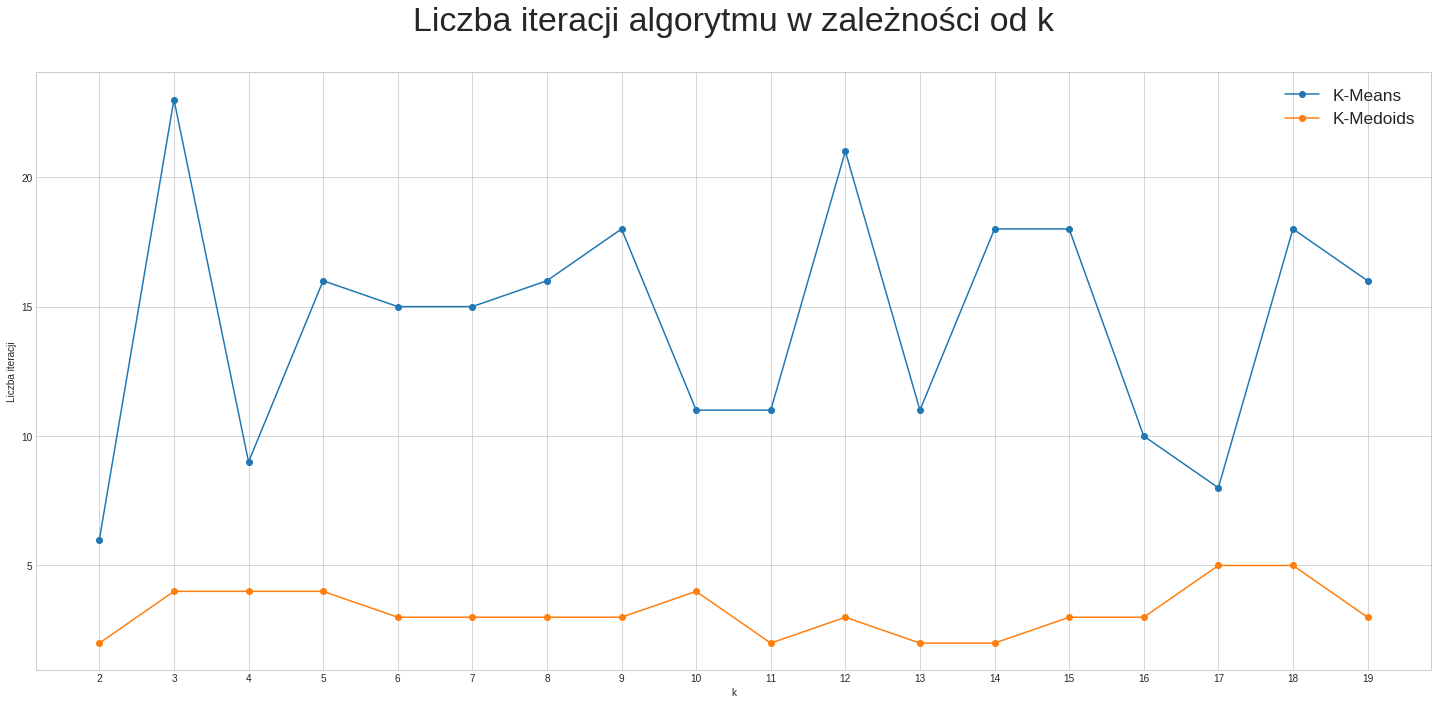

In [106]:
plt.title('Liczba iteracji algorytmu w zależności od k\n',size=34)
plt.plot(np.arange(2,20),[kmeans.kmeans(df.values,df.loc[np.random.choice(np.arange(df.shape[0]),size=k,replace=False)],ccore=False).process()[1] for k in np.arange(2,20)], marker = 'o', label='K-Means')
plt.plot(np.arange(2,20),[kmedoids.kmedoids(df.values,np.random.choice(np.arange(df.shape[0]),size=k,replace=False),ccore=False).process()[1] for k in np.arange(2,20)], marker = 'o', label='K-Medoids')
plt.xticks(np.arange(2,20))
plt.xlabel('k')
plt.ylabel('Liczba iteracji')
plt.legend(fontsize='xx-large')
plt.show()